In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define paths to dataset folders
resume_folder = "/kaggle/input/dataset/data/resumes"
non_resume_folder = "/kaggle/input/dataset/data/non-resumes"

# Output paths for augmented images
augmented_resume_folder = "/kaggle/working/augmented_data/resume"
augmented_non_resume_folder = "/kaggle/working/augmented_data/non_resume"

# output directories 
os.makedirs(augmented_resume_folder, exist_ok=True)
os.makedirs(augmented_non_resume_folder, exist_ok=True)


In [3]:
# Function to perform data augmentation and save augmented images
def augment_and_save(input_folder, output_folder, prefix, augmentations=5):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    # Get a list of image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')]
    
    for image_file in image_files:
        img_path = os.path.join(input_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels) for flow method
        
        # Generate augmented images
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=output_folder, save_prefix=prefix, save_format='jpg'):
            i += 1
            if i >= augmentations:
                break

# Perform data augmentation for resume images
augment_and_save(resume_folder, augmented_resume_folder, 'resume')

# Perform data augmentation for non-resume images
augment_and_save(non_resume_folder, augmented_non_resume_folder, 'non_resume')

# Display a sample augmented image
sample_augmented_image_path = os.path.join(augmented_resume_folder, os.listdir(augmented_resume_folder)[0])
sample_augmented_image = cv2.imread(sample_augmented_image_path)
sample_augmented_image = cv2.cvtColor(sample_augmented_image, cv2.COLOR_BGR2RGB)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


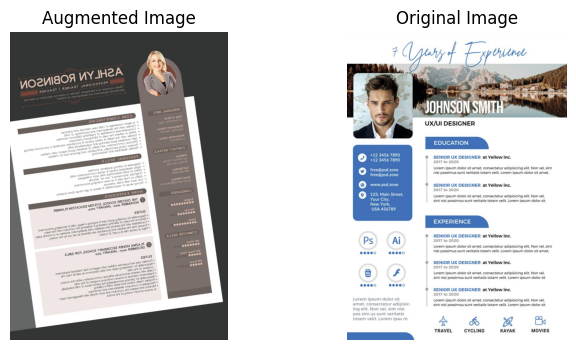

In [4]:
# Display the original and augmented images side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_augmented_image)
plt.title('Augmented Image')
plt.axis('off')

plt.subplot(1, 2, 2)
original_image_path = os.path.join(resume_folder, os.listdir(resume_folder)[0])
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.show()

In [5]:
# Set the input paths
train_data_dir = "/kaggle/working/augmented_data"
test_data_dir = "/kaggle/input/images-testing/test_data"

# Set the image size according to the MobileNetV2 input size
img_size = (224, 224)

# Create a MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(img_size[0], img_size[1], 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  ##Dense(2, activation='softmax') ***
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

# Display the model summary
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2586177 (9.87 MB)
Trainable params: 328193 (1.25 MB)
Non-trainable params: 2257984 (8.61 MB)
__________________

In [6]:
# Set hyperparameters
batch_size = 16
epochs = 20
# augmentation_factor = 3  # Number of times to augment the data

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary', ##categorical***
    subset='training',
    interpolation='nearest',
    shuffle=True)

valid_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary', 
    subset='validation',
    interpolation='nearest',
    shuffle=True)


# testing data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 464 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [9]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [10]:
from livelossplot.inputs.keras import PlotLossesCallback
plot_loss = PlotLossesCallback()

In [11]:
# Define callbacks 
checkpoint = ModelCheckpoint("resume_classifier.h5", 
                             monitor='val_accuracy', 
                             save_best_only=True, mode='max', verbose=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=4)

callbacks = [checkpoint, early_stopping, learning_rate, plot_loss]

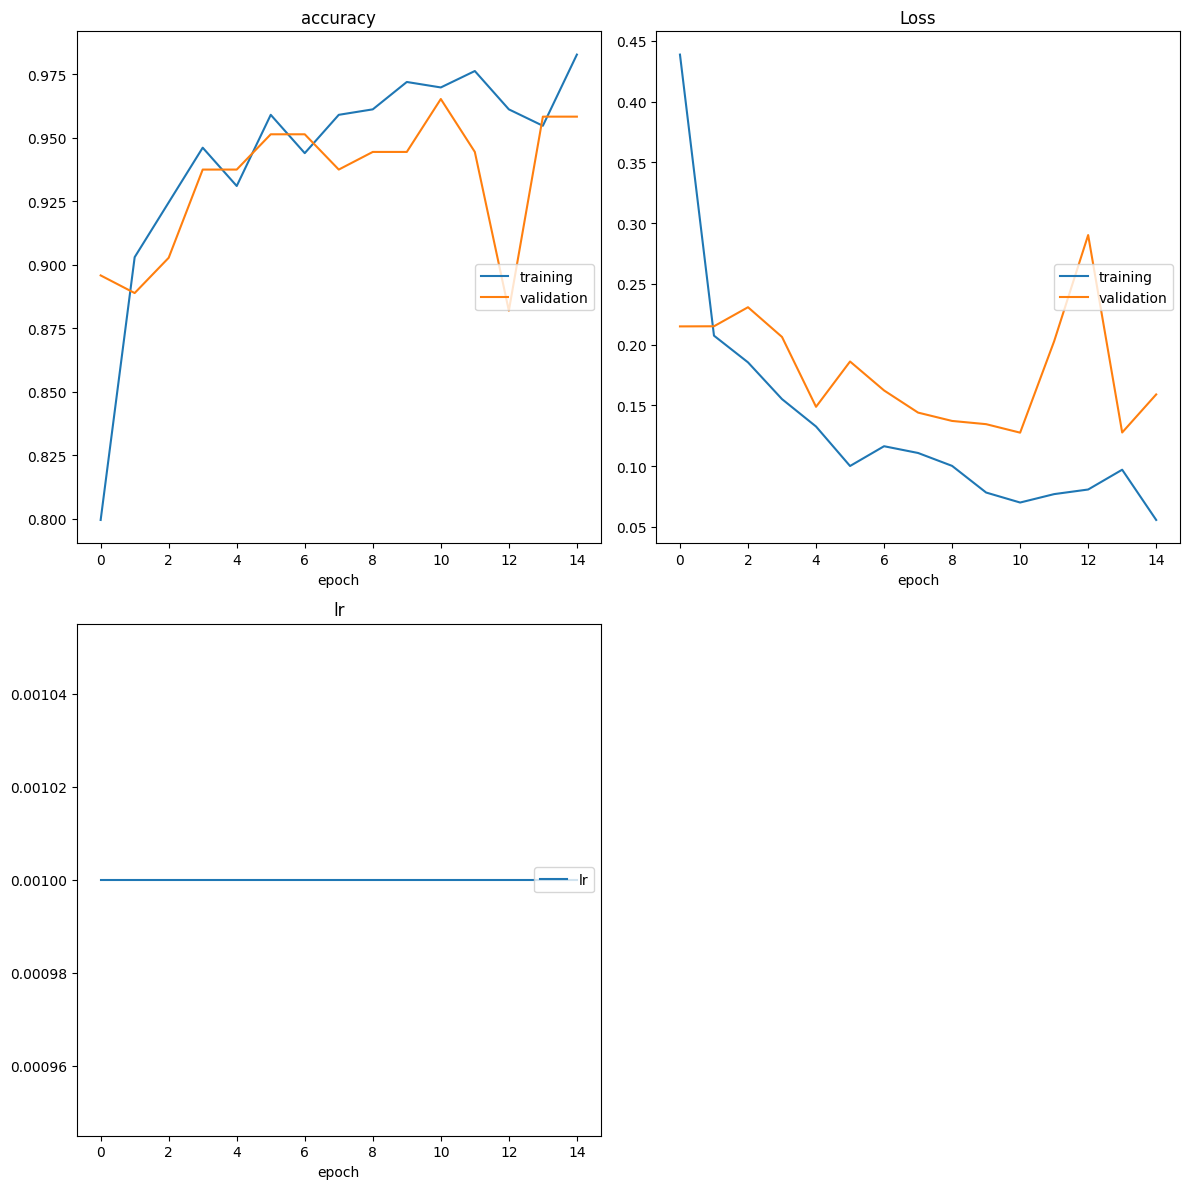

accuracy
	training         	 (min:    0.800, max:    0.983, cur:    0.983)
	validation       	 (min:    0.882, max:    0.965, cur:    0.958)
Loss
	training         	 (min:    0.056, max:    0.439, cur:    0.056)
	validation       	 (min:    0.127, max:    0.290, cur:    0.159)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
29/29 [==============================] - 13s 468ms/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 0.1589 - val_accuracy: 0.9583 - lr: 0.0010


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size, #(*augmentation_factor)
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // batch_size, 
    callbacks = callbacks
)

# Save the trained model
model.save("resume_classifier_model.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2/2 [==============================] - 1s 506ms/step - loss: 0.2954 - accuracy: 0.8500
Test Loss: 0.2954
Test Accuracy: 85.00%
2/2 [==============================] - 1s 27ms/step


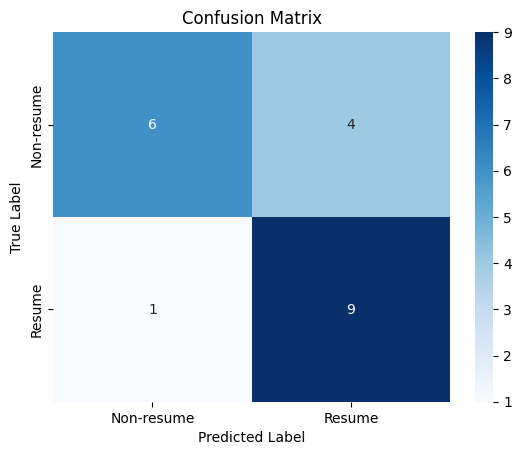


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



In [13]:
# Load the trained model
model.load_weights("resume_classifier_model.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions on the test set
predictions = model.predict(test_generator)

# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Create a confusion matrix
cm = confusion_matrix(test_generator.classes, binary_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-resume', 'Resume'], yticklabels=['Non-resume', 'Resume'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_generator.classes, binary_predictions))


In [14]:
# Calculate and print precision, recall, and F1-score
# tn=true negative, fp=false positive, fn=false negative, tp=true positive
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")



Metrics:
Precision: 0.6923
Recall: 0.9000
F1-Score: 0.7826


In [15]:
training_accuracy = model.evaluate(train_generator)

29/29 [==============================] - 9s 313ms/step - loss: 0.0476 - accuracy: 0.9892


In [16]:
validation_accuracy = model.evaluate(valid_generator)

10/10 [==============================] - 4s 367ms/step - loss: 0.1042 - accuracy: 0.9481


In [17]:
testing_accuracy = model.evaluate(test_generator)

2/2 [==============================] - 0s 183ms/step - loss: 0.2954 - accuracy: 0.8500
